## Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

In [2]:
data = pd.read_csv("Mall_Customers.csv")

In [3]:
data = data.drop("CustomerID", axis=1)

In [4]:
def gender(x): 
    if x["Gender"] == "Male": 
        return 0
    else: 
        return 1

In [5]:
data["Gender"] = data.apply(gender, axis=1)

In [6]:
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


## 0. EDA

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
Gender                    200 non-null int64
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4)
memory usage: 6.4 KB


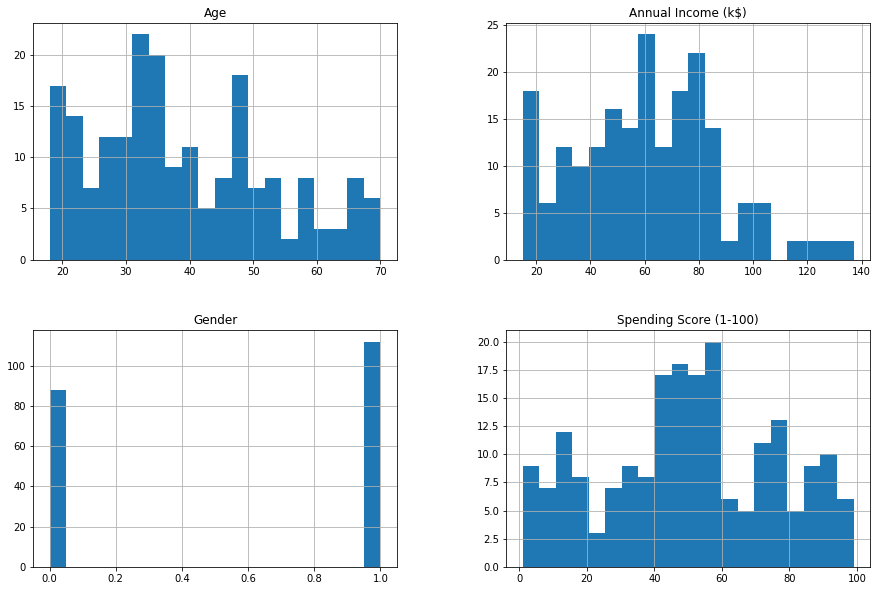

In [8]:
data.hist(bins=20,figsize=(15,10))
plt.show()

In [9]:
# 변수 각각의 단위가 다르므로 feature scaling을 진행함 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_sc = scaler.fit_transform(data)

C:\Users\LG\venv\jbeen\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [10]:
data = pd.DataFrame(data_sc, columns = data.columns)
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,0.019231,0.000000,0.387755
1,0.0,0.057692,0.000000,0.816327
2,1.0,0.038462,0.008197,0.051020
3,1.0,0.096154,0.008197,0.775510
4,1.0,0.250000,0.016393,0.397959


## 1. Hierarchical Clustering
* 계층적 군집화: 개체들을 가까운 집단부터 차근차근 묶어나가는 방식 

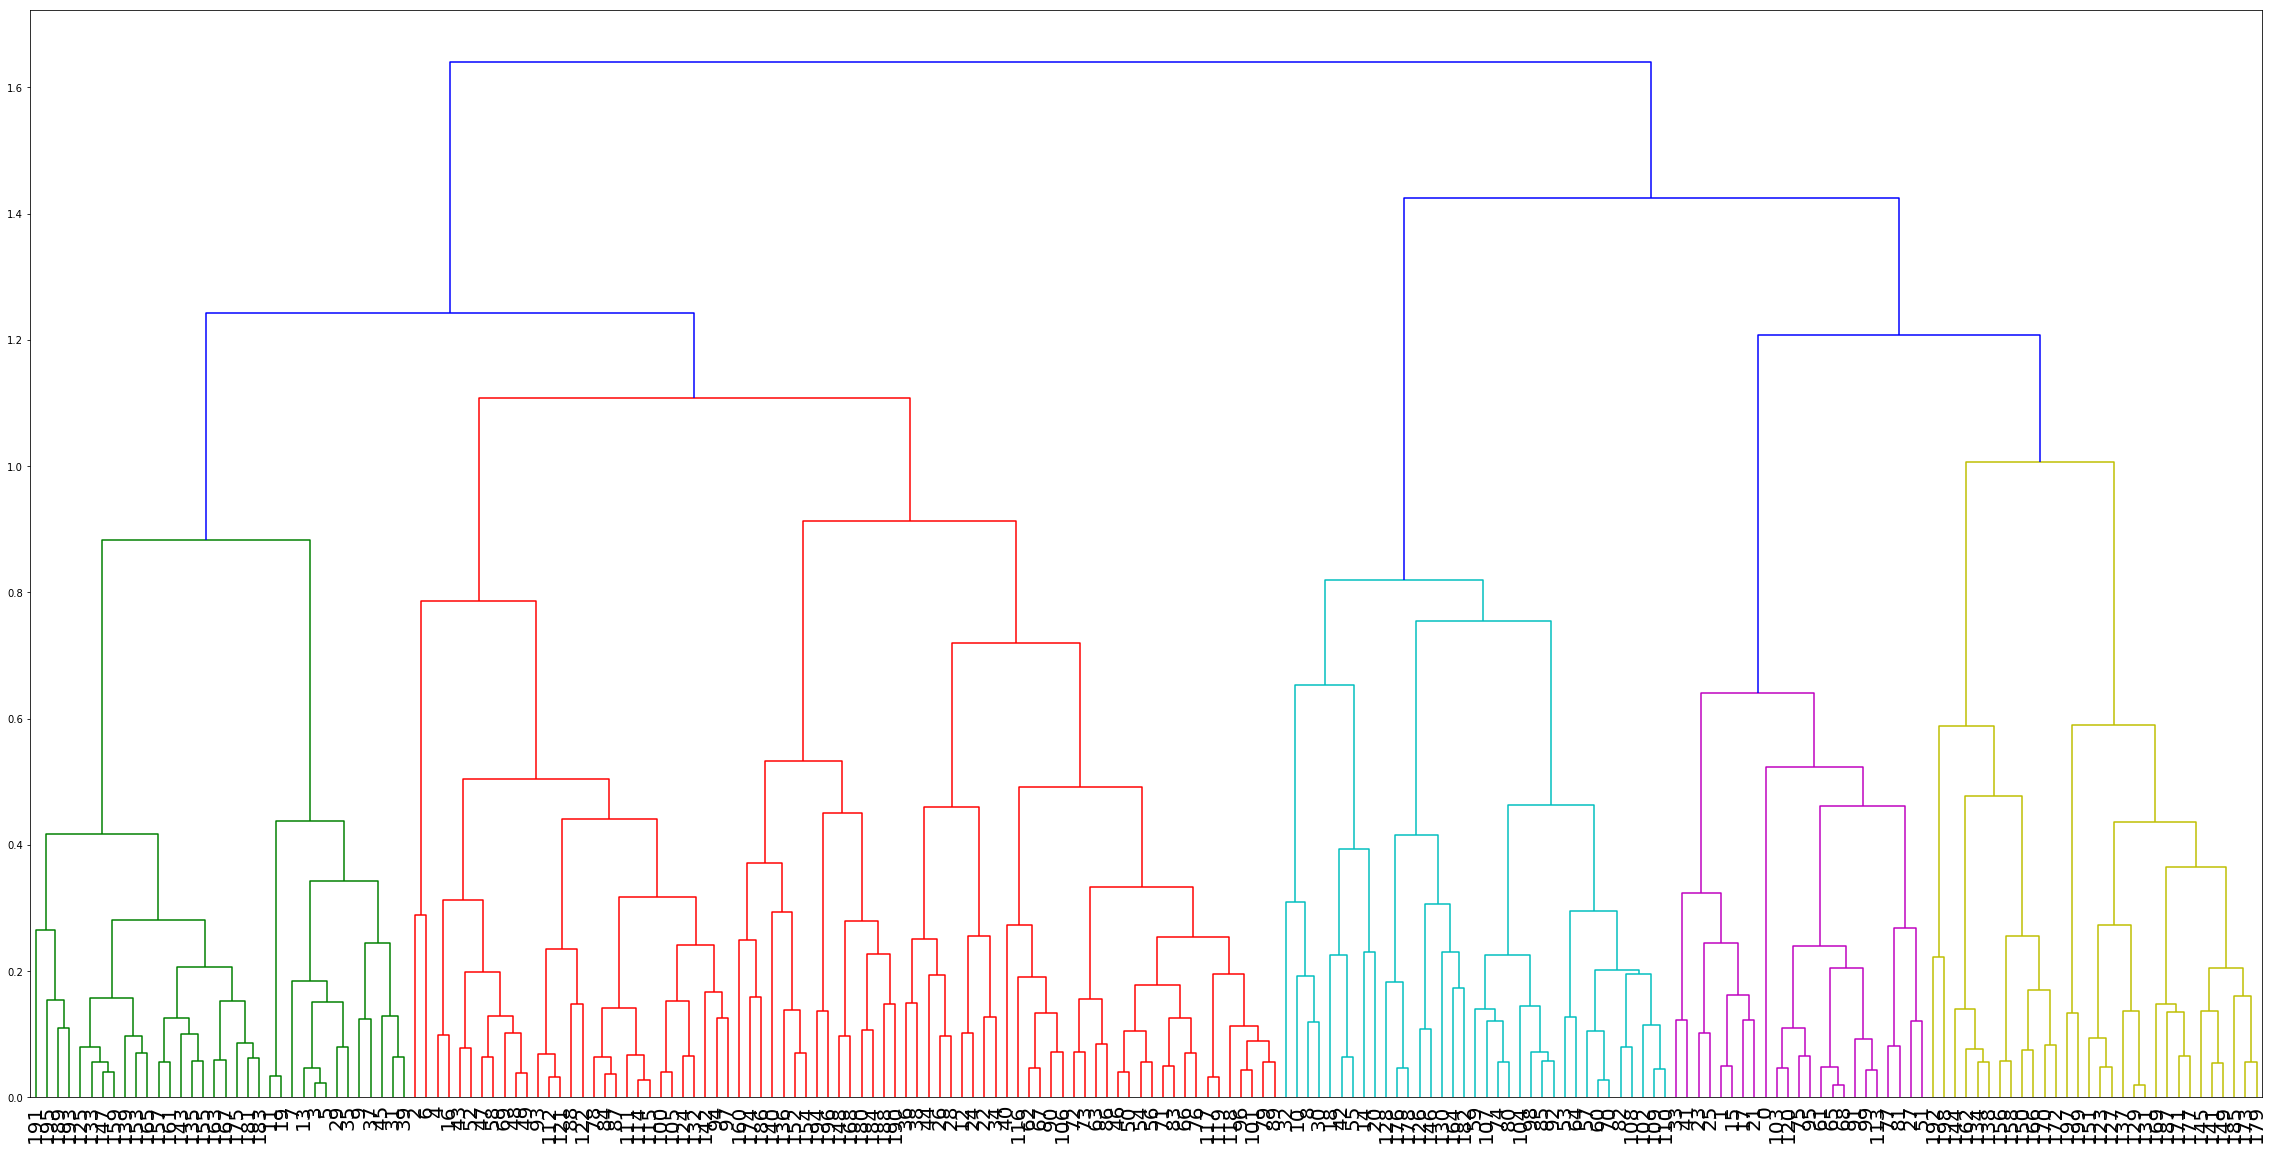

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram

mergings = linkage(data, method='complete')

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(40,20))
dendrogram(mergings,
           leaf_rotation=90,
           leaf_font_size=20,
)
plt.show()

* 클러스터간의 거리가 1.4인 지점에서 잘라, 3개의 cluster를 형성한다

In [12]:
from scipy.cluster.hierarchy import fcluster

predict = pd.DataFrame(fcluster(mergings,1.4,criterion='distance'))
predict.columns=['predict']

predict

,predict
0,3
1,3
2,1
3,1
4,1
...,...
195,1
196,1
197,3
198,3


In [13]:
pred_count = predict["predict"].value_counts()

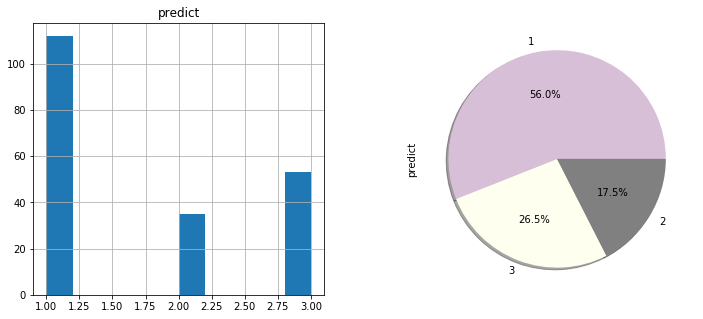

In [14]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(12,5)

predict.hist(ax = axes[0])
pred_count.plot.pie(autopct='%1.1f%%',shadow=True, colors =['thistle', 'ivory', 'grey'], ax = axes[1]) 

* 3개의 군집으로 나누었을 때 각각의 군집의 비율은 위의 그림과 같다 

## 2. K-means Clustering
* 비계층적 군집화: 전체 데이터의 영역을 특정 기준에 의해 동시에 구분 
* Center-based Clustering: 동일한 군집에 속하는 데이터는 "어떠한 중심"을 기준으로 분포할 것이다 라는 가정 기반 

In [15]:
feature = data[['Gender','Age','Annual Income (k$)','Spending Score (1-100)']]

In [16]:
from sklearn.cluster import KMeans

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto')
model.fit(feature)

predict = pd.DataFrame(model.predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

In [17]:
r.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),predict
0,0.0,0.019231,0.000000,0.387755,2
1,0.0,0.057692,0.000000,0.816327,2
2,1.0,0.038462,0.008197,0.051020,0
3,1.0,0.096154,0.008197,0.775510,0
4,1.0,0.250000,0.016393,0.397959,0


In [18]:
predict["predict"].value_counts()

0    112
1     48
2     40
Name: predict, dtype: int64

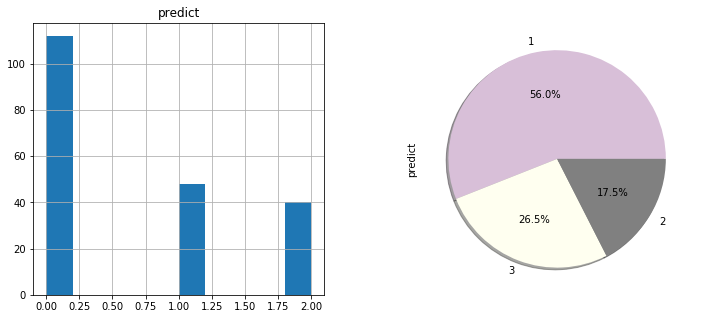

In [19]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(12,5)

predict.hist(ax = axes[0])
pred_count.plot.pie(autopct='%1.1f%%',shadow=True, colors =['thistle', 'ivory', 'grey'], ax = axes[1]) 

* 3개의 군집으로 나누었을 때 각각의 군집의 비율은 위의 그림과 같다
* 비계층적 군집화 방식에서의 군집의 비율과 동일한 형태를 보인다 

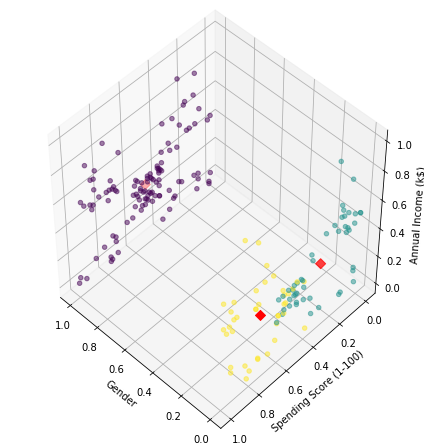

In [20]:
centers = pd.DataFrame(model.cluster_centers_,columns=['Gender','Age','Annual Income (k$)','Spending Score (1-100)'])
center_x = centers['Gender']
center_y = centers['Spending Score (1-100)']
center_z = centers['Annual Income (k$)']

from mpl_toolkits.mplot3d import Axes3D

# scatter plot
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Gender'],r['Spending Score (1-100)'],r['Annual Income (k$)'],c=r['predict'],alpha=0.5)
ax.scatter(center_x,center_y,center_z,s=50,marker='D',c='r')
ax.set_xlabel('Gender')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Annual Income (k$)')
plt.show()

* 빨간색 점은 각각 군집에서의 중심점 
* 군집의 중심점들 사이의 거리가 많이 떨어져 있다 

### +) 최적의 군집 수 K 결정 (Elbow Point)

Text(0.5, 1.0, 'Elbow curve')

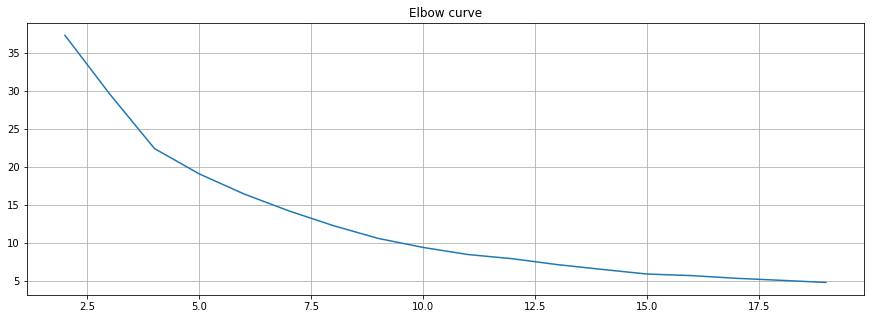

In [21]:
X = feature
distorsions = []

# 군집 수 K의 변화에 따라
# Inertia Value: 군집화가 된 후에, 각 중심점에서 군집내의 데이터간의 거리를 합산한 것
# 즉, 군집의 응집도를 나타내는 값
# 이 값을 구해 그래프로 그린다!

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

# 급격하게 하강하다가 변화의 폭이 크지 않는 지점 Elbow Point를 찾는다.

* 군집 수가 3일 때, elbow point로 보인다

In [22]:
from sklearn.metrics import silhouette_score
silhouette_score(feature, predict)

C:\Users\LG\venv\jbeen\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4583525581125425

* 실루엣 스코어가 0.5에 가까우므로, 군집이 괜찮게 나누어졌다고 생각할 수 있다 

## 3. DBSCAN
* 비계층적 군집화: 전체 데이터의 영역을 특정 기준에 의해 동시에 구분 
* Density-based Clustering: 동일한 군집에 속하는 데이터는 서로 근접하게 분포할 것이다 라는 가정 기반 

In [23]:
from sklearn.cluster import DBSCAN

# create model and prediction
model = DBSCAN(eps=0.3,min_samples=6)
predict = pd.DataFrame(model.fit_predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

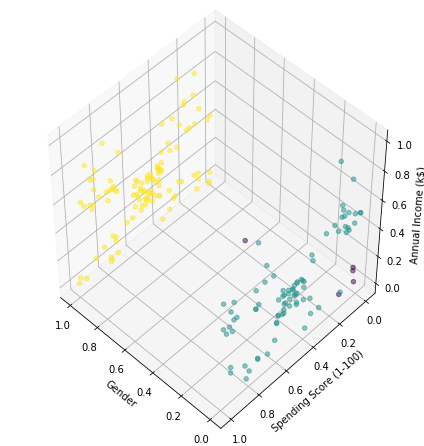

In [24]:
from mpl_toolkits.mplot3d import Axes3D

# scatter plot
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Gender'],r['Spending Score (1-100)'],r['Annual Income (k$)'],c=r['predict'],alpha=0.5)
ax.set_xlabel('Gender')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Annual Income (k$)')
plt.show()

### +) k-dist graph
* 최적의 eps, minpts를 선정하는 그래프

In [25]:
from sklearn.neighbors import NearestNeighbors

X = feature

neigh = NearestNeighbors(n_neighbors=6)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

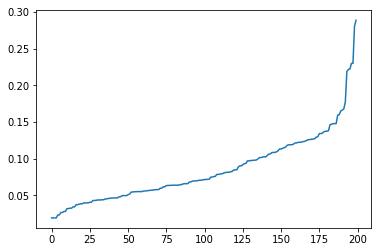

In [26]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

* 185개의 점은 거리 0.17 이내에 적어도 6개의 점을 갖는다. 

#### 선택한 eps, minpts 값으로 DBSCAN 다시 진행 

In [27]:
# create model and prediction
model = DBSCAN(eps=0.17,min_samples=6)
predict = pd.DataFrame(model.fit_predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

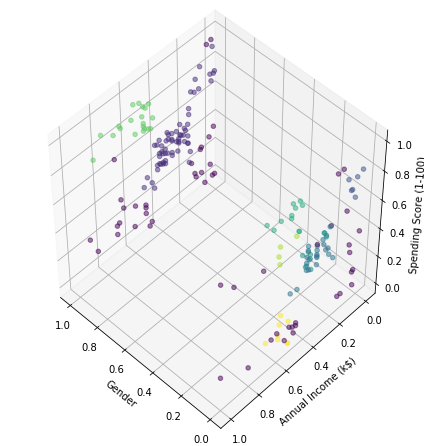

In [28]:
# scatter plot
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Gender'],r['Annual Income (k$)'],r['Spending Score (1-100)'],c=r['predict'],alpha=0.5)
ax.set_xlabel('Gender')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.show()

In [29]:
from sklearn.metrics import silhouette_score
silhouette_score(feature, predict)

C:\Users\LG\venv\jbeen\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.14789300618524515

* 실루엣스코어가 좋지 않은 것으로 보아 해당 데이터에는   
밀도 기반으로 군집을 나눈 DBSCAN보다는 K-Means Clustering의 방법이 더 좋다고 생각된다 

## 4. 새로운 방법: SpectralClustering
* Spectral Clustering: 개체간의 거리를 가지고 만든 adjancency matrix를 활용해 클러스러팅하는 것 
* 개체 간 거리가 멀리 떨어져 있을수록 (=유사하지 않을수록) 그 가중치는 줄어드는 방식 


* 군집을 n개 이상으로 쪼갤 때는 2개로 쪼개는 것을 연속으로 해주는 것과 같음
* (그래프를 2개의 클러스터로 나누기 위한 수많은 방법) 중에서 (잃어버리는 weight가 가장 작은 방법)을 선택

In [30]:
from sklearn.cluster import SpectralClustering

# n_clusters: 3개의 군집, affinity=인접행렬 설정 시 radial basis function 사용, n_init: centroid seeds
model = SpectralClustering(n_clusters=3, affinity='rbf', n_init=6) 

predict = pd.DataFrame(model.fit_predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

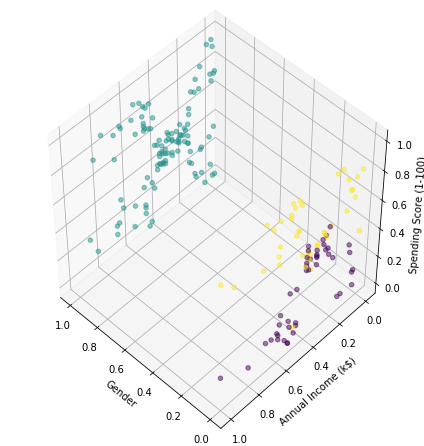

In [31]:
# scatter plot
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Gender'],r['Annual Income (k$)'],r['Spending Score (1-100)'],c=r['predict'],alpha=0.5)
ax.set_xlabel('Gender')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.show()

In [32]:
silhouette_score(feature, predict)

C:\Users\LG\venv\jbeen\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4573965431493555

* 실루엣 스코어가 0.5에 가까우므로, 군집이 괜찮게 나누어졌다고 생각할 수 있다